In [2]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import scipy.signal as sig
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [3]:
labels = pd.read_csv('data_labels\CIS-PD_Training_Data_IDs_Labels.csv')
labels.subject_id = labels.subject_id.astype(str)

labels[["on_off", "tremor", "dyskinesia"]].corr()


,on_off,tremor,dyskinesia
on_off,1.00000,0.390800,0.352530
tremor,0.39080,1.000000,0.562339
dyskinesia,0.35253,0.562339,1.000000


In [4]:
null = pd.read_csv('null_solution.csv')
tremor_preds=null[["subject_id", "tremor"]]
tremor_preds=tremor_preds.rename(columns={"tremor":"tremor_null"})
labels=pd.merge(labels, tremor_preds, how="left", on=["subject_id"])


1.0    633
0.0    513
2.0    205
3.0    102
4.0      9
Name: tremor, dtype: int64


Text(0, 0.5, 'Frequency')

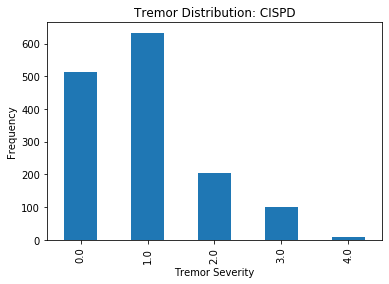

In [5]:
print(labels['tremor'].value_counts())
labels['tremor'].value_counts().sort_index().plot(kind='bar')
plt.title('Tremor Distribution: CISPD')
plt.xlabel('Tremor Severity')
plt.ylabel('Frequency')


In [7]:
pd.pivot_table(labels[["subject_id","tremor"]], index="subject_id", columns=["tremor"],aggfunc=len)

tremor,0.0,1.0,2.0,3.0,4.0
subject_id,,,,,
1004,41.0,16.0,10.0,14.0,1.0
1006,12.0,18.0,7.0,NaN,NaN
1007,210.0,80.0,9.0,NaN,NaN
1019,7.0,24.0,14.0,NaN,NaN
1020,15.0,156.0,24.0,NaN,NaN
1023,74.0,28.0,3.0,1.0,NaN
1032,105.0,70.0,2.0,NaN,NaN
1034,20.0,19.0,1.0,NaN,NaN
1038,1.0,134.0,71.0,1.0,NaN


In [8]:
"""define frequency bands the step function"""
W_n = [3,7];

"""Select the step function"""
Ord = sig.buttord(wp = [4,6],ws =[3,7],gpass =0.08, gstop = 10,fs = 50)
Filter = sig.butter(Ord[0],Wn = W_n,btype = 'bandpass',fs =50);

Text(0.5, 0, 'Frequency[Hz]')

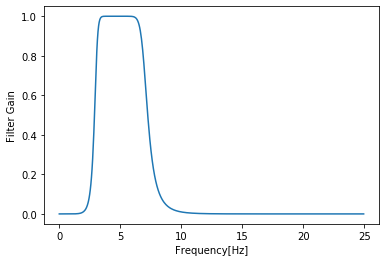

In [9]:
"""Plot the frequency response"""
Response = sig.freqz(Filter[0],Filter[1],fs=50)

plt.plot(Response[0],np.abs(Response[1]))
plt.ylabel("Filter Gain");
plt.xlabel("Frequency[Hz]")

In [15]:
#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'training_data\CIS_training'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means=[]
for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    
   
    """Apply Hypothesis tests to check if means are statistically significant????"""
    #Relevant features 
    measurement_id = os.path.basename(csvfile)
    measurement_id = measurement_id.replace(".csv","")
    
    df["r"] = np.sqrt(df.X**2+df.Y**2+df.Z**2)
    dr = np.sqrt(np.diff(df.X)**2+np.diff(df.Y)**2+np.diff(df.Z)**2)
    mean_r = np.median(df.r)
    std_r = np.std(df.r)
    min_r = np.min(df.r)
    max_r = np.max(df.r)
    skew_r = skew(df.r)
    kurtosis_r = kurtosis(df.r)
    
    mean_dr = np.median(dr)
    std_dr = np.std(dr)
    min_dr = np.min(dr)
    max_dr = np.max(dr)
    skew_dr = skew(dr)
    kurtosis_dr = kurtosis(dr)
    
    """Extract frequency bands in Hz"""
    FreqBandx = sig.lfilter(Filter[0],Filter[1],df["X"]);
    FreqBandy = sig.lfilter(Filter[0],Filter[1],df["Y"]);
    FreqBandz = sig.lfilter(Filter[0],Filter[1],df["Z"]);
    
    """Find the power in each frequency Band"""
    PowerFreqBandx = np.abs(FreqBandx)**2;
    PowerFreqBandy = np.abs(FreqBandy)**2;
    PowerFreqBandz = np.abs(FreqBandz)**2;
    
    """Sum the power in each frequency band"""
    SumPowerFreqBandx = np.sum(PowerFreqBandx);
    SumPowerFreqBandy = np.sum(PowerFreqBandy);
    SumPowerFreqBandz = np.sum(PowerFreqBandz);
    
    """Sum the total signal power"""
    Powerx = np.sum(df["X"]**2);
    Powery = np.sum(df["Y"]**2);
    Powerz = np.sum(df["Z"]**2);
    
    """Find the percentage of power in frequencies of interest"""
    FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));
    
    Means.append([measurement_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, 
                     mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])

In [16]:
accel_phones= pd.DataFrame(Means, columns=["measurement_id", "mean_r", "std_r", 
                                              "min_r", "max_r", "skew_r", "kurtosis_r",
                                              "mean_dr", "std_dr", "min_dr", "max_dr", 
                                              "skew_dr", "kurtosis_dr","FreqPower"])
   



In [18]:
accel_phones.shape

(1858, 14)

In [19]:
data=pd.merge(accel_phones, labels, on="measurement_id")
data.shape

(1858, 19)

In [20]:
data.head()

,measurement_id,mean_r,std_r,min_r,max_r,skew_r,kurtosis_r,mean_dr,std_dr,min_dr,max_dr,skew_dr,kurtosis_dr,FreqPower,subject_id,on_off,dyskinesia,tremor,tremor_null
0,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.995006,0.109462,0.155396,4.148789,5.416649,89.417141,0.008090,0.136909,0.000000,3.775578,5.483257,53.134543,0.113031,1038,4.0,0.0,2.0,1.347826
1,00544f67-c07c-4a07-9c17-a7aee51d8b96,0.996147,0.159688,0.090525,4.201611,2.299388,20.792235,0.087323,0.155427,0.000000,3.832981,4.438531,45.169433,0.125117,1049,2.0,1.0,2.0,1.817073
2,005685b2-3de4-469b-b673-8f937ee8196e,1.000097,0.199510,0.186133,3.020230,0.793835,5.868388,0.033265,0.092974,0.000488,3.208620,4.668803,67.681713,0.099959,1044,0.0,0.0,NaN,NaN
3,00bbb4c4-bb9a-4c3a-9c1b-3bf5f079d336,0.997932,0.057611,0.349685,2.491713,2.042505,43.852060,0.024966,0.055826,0.000000,2.384465,8.703556,175.746593,0.043412,1006,0.0,NaN,1.0,0.864865
4,00c6a1c3-178d-4f21-ba88-512c4a734541,0.997728,0.019403,0.648807,1.545145,3.033917,96.274044,0.005945,0.030695,0.000000,2.207027,23.447582,1083.219213,0.016613,1032,1.0,NaN,0.0,0.418079


In [21]:
df_tremors=data.drop(['on_off', 'dyskinesia', 'measurement_id'], axis=1)
df_tremors=df_tremors.dropna()

In [22]:
train, test = train_test_split(df_tremors, test_size=0.2, random_state=42, stratify=df_tremors['subject_id'])

print(train.shape)
print(test.shape)


(1169, 16)
(293, 16)


In [23]:
train.head()

,mean_r,std_r,min_r,max_r,skew_r,kurtosis_r,mean_dr,std_dr,min_dr,max_dr,skew_dr,kurtosis_dr,FreqPower,subject_id,tremor,tremor_null
931,1.002893,0.113817,0.129478,4.627887,4.290964,76.670636,0.087982,0.137398,0.000488,4.649109,6.344504,95.517662,0.072121,1023,0.0,0.349057
376,1.001977,0.132044,0.124793,3.757843,2.741595,24.170405,0.066259,0.117227,0.000488,3.087314,5.457114,60.830328,0.095490,1049,3.0,1.817073
1715,1.002603,0.383135,0.128898,14.276652,12.191211,275.106053,0.089031,0.322878,0.000488,21.164378,22.739010,917.262761,0.160735,1023,1.0,0.349057
1724,0.995019,0.073106,0.104017,5.628973,7.879459,347.352999,0.019742,0.078100,0.000000,6.023360,20.638361,1126.322020,0.061398,1020,2.0,1.046154
32,1.001253,0.038670,0.406919,1.758441,1.151559,33.537490,0.011980,0.040678,0.000000,0.789163,6.289757,58.676933,0.044491,1038,1.0,1.347826


In [24]:
cols_to_transform=train.columns[:-3]
scaler= StandardScaler()
#scaler=MinMaxScaler()
scaler= scaler.fit(train[cols_to_transform])
train[cols_to_transform] = scaler.transform(train[cols_to_transform])
test[cols_to_transform] = scaler.transform(test[cols_to_transform])


C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\lisbe\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [25]:
X_train = train.drop(['tremor', 'tremor_null'], axis=1)
y_train = train.tremor
null_train = train.tremor_null
X_test=test.drop(['tremor', 'tremor_null'], axis=1)
y_test = test.tremor
null_test = test.tremor_null

In [26]:
X_train_dummies = pd.get_dummies(X_train)
X_test_dummies= pd.get_dummies(X_test)


In [27]:
print(X_train_dummies.shape)
print(X_test_dummies.shape)
print(y_train.shape)
print(y_test.shape)

(1169, 26)
(293, 26)
(1169,)
(293,)


In [28]:
X_train_dummies.to_csv('X_train_tremor.csv', index=False)
X_test_dummies.to_csv('X_test_tremor.csv', index=False)
y_train.to_csv('y_train_tremor.csv', index=False)
y_test.to_csv('y_test_tremor.csv', index=False)

C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [34]:
knn = KNeighborsClassifier()

knn_grid = {
    'n_neighbors': np.arange(1,25),
}

knn_cv = GridSearchCV(knn, knn_grid, cv=5)
knn_cv.fit(X_train_dummies, y_train)
knn_cv.best_params_
knn_cv.best_score_

knn = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])
knn.fit(X_train_dummies, y_train)
y_pred = knn.predict(X_test_dummies)
print("accuracy knn:" , str(metrics.accuracy_score(y_test, y_pred)))
print("MSE KNN:", str(metrics.mean_squared_error(y_test, y_pred)))
print("NULL KNN:", str(metrics.mean_squared_error(y_test, null_test)))


accuracy knn: 0.5870307167235495
MSE KNN: 0.7713310580204779
NULL KNN: 0.3601817375099345


In [ ]:
#GridsearchCV


classifier = RandomForestClassifier(random_state = 42)

rf_grid = {
    'n_estimators': np.arange(100,500,100),
    'max_depth': np.arange(10,50,10),
    'min_samples_leaf': np.arange(1,10),
    'min_samples_split': np.arange(2,10,2),
    'criterion':['gini', 'entropy']
}

rf_cv = GridSearchCV(classifier, rf_grid, cv=5)
rf_cv.fit(X_train_dummies, y_train)
rf_cv.best_params_
rf_cv.best_score_

classifier = RandomForestClassifier(n_estimators = rf_cv.best_params_['n_estimators'], 
                                    criterion = rf_cv.best_params_['criterion'] , 
                                    random_state = 42,
                                    max_depth = rf_cv.best_params_['max_depth'],
                                    min_samples_split = rf_cv.best_params_['min_samples_split'],
                                    min_samples_leaf=rf_cv.best_params_['min_samples_leaf'])


In [ ]:
classifier.fit(X_train_dummies, y_train)
y_pred = classifier.predict(X_test_dummies)
print("accuracy rf:", str(metrics.accuracy_score(y_test, y_pred)))
print("MSE RF:" , str(metrics.mean_squared_error(y_test,y_pred)))
print("NULL RF:", str(metrics.mean_squared_error(y_test, null_test)))

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

In [36]:
import xgboost as xgb

dtrain=xgb.DMatrix(data=X_train_dummies, label=y_train)
dtest = xgb.DMatrix(data=X_test_dummies)

C:\Users\lisbe\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lisbe\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [37]:
param = {'objective': 'multi:softmax',
         'num_class': 5,
         'max_depth' : 5,
         'learning_rate': 0.4
        }
bst = xgb.train(param, dtrain)
xgb_pred = bst.predict(dtest)

In [39]:

xgb_clf = xgb.XGBClassifier(objective = 'multi:softmax', num_class = 5, max_depth = 5, learning_rate = 0.4)
xgb_clf.fit(X_train_dummies, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=5, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

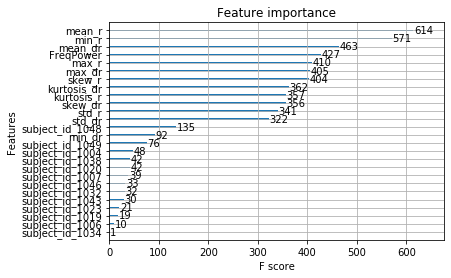

In [40]:
xgb.plot_importance(xgb_clf)

In [38]:

print("accuracy xgb:", str(metrics.accuracy_score(y_test, xgb_pred)))
print("MSE XGB:" , str(metrics.mean_squared_error(y_test,xgb_pred)))
print("NULL XGB:", str(metrics.mean_squared_error(y_test, null_test)))

print(metrics.confusion_matrix(y_test, xgb_pred))
print(metrics.classification_report(y_test,xgb_pred))


accuracy xgb: 0.6655290102389079
MSE XGB: 0.4880546075085324
NULL XGB: 0.3601817375099345
[[91 19  0  0  0]
 [33 81  5  1  0]
 [ 3 21 11  3  0]
 [ 3  2  6 12  0]
 [ 0  0  1  1  0]]
              precision    recall  f1-score   support

         0.0       0.70      0.83      0.76       110
         1.0       0.66      0.68      0.67       120
         2.0       0.48      0.29      0.36        38
         3.0       0.71      0.52      0.60        23
         4.0       0.00      0.00      0.00         2

    accuracy                           0.67       293
   macro avg       0.51      0.46      0.48       293
weighted avg       0.65      0.67      0.65       293



C:\Users\lisbe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
param = {'objective': 'reg:squarederror',
         'max_depth' : 5,
         'learning_rate': 0.4
        }
bst = xgb.train(param, dtrain)
xgb_pred = bst.predict(dtest)

In [43]:
print("MSE XGB:" , str(metrics.mean_squared_error(y_test,xgb_pred)))
print("NULL XGB:", str(metrics.mean_squared_error(y_test, null_test)))


MSE XGB: 0.4049827589499749
NULL XGB: 0.3601817375099345


## TESTING

In [ ]:

#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'testing_data\CIS_testing'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means=[]
for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    
    measurement_id = os.path.basename(csvfile)
    measurement_id = measurement_id.replace(".csv","")
    
    df["r"] = np.sqrt(df.X**2+df.Y**2+df.Z**2)
    dr = np.sqrt(np.diff(df.X)**2+np.diff(df.Y)**2+np.diff(df.Z)**2)
    mean_r = np.median(df.r)
    std_r = np.std(df.r)
    min_r = np.min(df.r)
    max_r = np.max(df.r)
    skew_r = skew(df.r)
    kurtosis_r = kurtosis(df.r)
    
    mean_dr = np.median(dr)
    std_dr = np.std(dr)
    min_dr = np.min(dr)
    max_dr = np.max(dr)
    skew_dr = skew(dr)
    kurtosis_dr = kurtosis(dr)
    
    """Extract frequency bands in Hz"""
    FreqBandx = sig.lfilter(Filter[0],Filter[1],df["X"]);
    FreqBandy = sig.lfilter(Filter[0],Filter[1],df["Y"]);
    FreqBandz = sig.lfilter(Filter[0],Filter[1],df["Z"]);
    
    """Find the power in each frequency Band"""
    PowerFreqBandx = np.abs(FreqBandx)**2;
    PowerFreqBandy = np.abs(FreqBandy)**2;
    PowerFreqBandz = np.abs(FreqBandz)**2;
    
    """Sum the power in each frequency band"""
    SumPowerFreqBandx = np.sum(PowerFreqBandx);
    SumPowerFreqBandy = np.sum(PowerFreqBandy);
    SumPowerFreqBandz = np.sum(PowerFreqBandz);
    
    """Sum the total signal power"""
    Powerx = np.sum(df["X"]**2);
    Powery = np.sum(df["Y"]**2);
    Powerz = np.sum(df["Z"]**2);
    
    """Find the percentage of power in frequencies of interest"""
    FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));
    
    Means.append([measurement_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, 
                     mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])
    
    """
    #Relevant features 
    measurement_id = csvfile[25:-4]
    
    #average
    mean_x = np.mean(df['X'])
    mean_y = np.mean(df['Y'])
    mean_z = np.mean(df['Z'])  
    
    #standard deviation
    std_x = np.std(df['X'])
    std_y = np.std(df['Y'])
    std_z = np.std(df['Z'])
    
    #minimum
    min_x = np.min(df['X'])
    min_y = np.min(df['Y'])
    min_z = np.min(df['Z'])
    
    #maximum
    max_x = np.max(df['X'])
    max_y = np.max(df['Y'])
    max_z = np.max(df['Z'])
    
    #skewness
    skew_x = skew(df['X'])
    skew_y = skew(df['Y'])
    skew_z = skew(df['Z'])
    
    #kurtosis
    kurtosis_x=kurtosis(df['X'])
    kurtosis_y=kurtosis(df['Y'])
    kurtosis_z=kurtosis(df['Z'])
    
    
    #median
    
    Means.append([measurement_id, 
                  mean_x, std_x, min_x, max_x, skew_x,kurtosis_x,
                  mean_y, std_y, min_y, max_y, skew_y,kurtosis_y,
                  mean_z, std_z, min_z, max_z, skew_z, kurtosis_z])
    

test_data = pd.DataFrame(Means, columns = ['measurement_id',
                                       'mean_x', 'std_x', 'min_x', 'max_x','skew_x', 'kurtosis_x',
                                       'mean_y', 'std_y', 'min_y', 'max_y', 'skew_y', 'kurtosis_y',
                                       'mean_z', 'std_z', 'min_z', 'max_z', 'skew_z', 'kurtosis_z']) 
   
"""

In [ ]:
test_data = pd.DataFrame(Means, columns=["measurement_id", "mean_r", "std_r", 
                                              "min_r", "max_r", "skew_r", "kurtosis_r",
                                              "mean_dr", "std_dr", "min_dr", "max_dr", 
                                              "skew_dr", "kurtosis_dr","FreqPower"])
   
test_data.head()

In [ ]:
test_subjects = pd.read_csv('testing_data\cis-pd.CIS-PD_Test_Data_IDs.csv')
test_subjects.subject_id = test_subjects.subject_id.astype(str)
test_subjects.head()

In [ ]:
test_subjects.subject_id.unique()==labels.subject_id.unique()

In [ ]:
df_test=pd.merge(test_data, test_subjects, on="measurement_id")
df_test.head()

In [ ]:
train = df_tremors.drop(['tremor', 'tremor_null'], axis=1)
train.head()

In [ ]:
cols_train = train.columns[:-1]
scaler = scaler.fit(train[cols_train])
train[cols_train] = scaler.transform(train[cols_train])
train.head()

In [ ]:
cols_test = df_test.columns[1:-1]
df_test[cols_test] = scaler.transform(df_test[cols_test])
df_test.head()


In [ ]:
df_test.subject_id.unique()

In [ ]:
df_tremors.subject_id.unique()

In [ ]:
test= pd.get_dummies(df_test[df_test.columns[1:]])
test = test.drop(['subject_id_1044', 'subject_id_1051', 'subject_id_1039'], axis=1)
test.head()

In [ ]:
train = pd.get_dummies(train)
train.head()

In [ ]:
dtrain=xgb.DMatrix(data=train, label=df_tremors.tremor)
dtest = xgb.DMatrix(data=test)

In [ ]:
param = {'objective': 'multi:softmax',
         'num_class': 5,
         'max_depth' : 5,
         'learning_rate': 0.4
        }
bst = xgb.train(param, dtrain)
xgb_pred = bst.predict(dtest)

In [ ]:
#make predictions on test class
knn = KNeighborsClassifier(n_neighbors=k)
df_X = pd.concat([X_t_train,X_t_test])
df_y = pd.concat([y_t_train, y_t_test])
knn.fit(df_X, df_y)
predictions= knn.predict(df_test[df_test.columns[1:]])

In [ ]:
#df_test['prediction']=predictions

In [ ]:
df_test.head()

In [ ]:
classifier.fit(df_X, df_y)

In [ ]:
predictions_forest = classifier.predict(df_test[df_test.columns[1:]])

In [ ]:
predictions_forest.shape

In [ ]:
test_subjects.shape

In [ ]:
df_test["prediction"]=xgb_pred

In [ ]:
df_test.head()

In [ ]:
df_test[['measurement_id', 'prediction']].to_csv("cis_pd_tremor_predictions.csv", index=False)